A ZFNet (Zeiler & Fergus Net) model involves modifying the original AlexNet architecture by fine-tuning certain hyperparameters like the size of the filters and the stride and pooling sizes. ZFNet was essentially designed to understand and visualize what each layer in a ConvNet learns, but it also provided improvements over AlexNet in terms of architecture adjustments. 

Step 1: Setup and Imports:

In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

Step 2: Preparing the Dataset

In [12]:
class Caltech101Dataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[index]
        return image, label

def load_dataset(dataset_path):
    image_paths, labels = [], []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".png"):
                path = os.path.join(root, file)
                label = root.split(os.sep)[-1]
                if label != "BACKGROUND_Google":  # Exclude background images
                    image_paths.append(path)
                    labels.append(label)
    return image_paths, labels


Step 3: Data Loading and Splitting

In [14]:
# Path to your dataset
dataset_path = './datasets/caltech101/101_ObjectCategories'

# Load the dataset
image_paths, labels = load_dataset(dataset_path)

# Encode labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = np.argmax(labels, axis=1)  # Convert to indices for CrossEntropyLoss

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=42)

# Transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# DataLoader
train_dataset = Caltech101Dataset(X_train, y_train, transform=transform)
test_dataset = Caltech101Dataset(X_test, y_test, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Step 4: Defining ZFNet

ZFNet tweaks AlexNet's architecture for better visualization and understanding. The changes are mainly in the first few layers, adjusting filter sizes, strides, and pooling sizes to maintain more image information through the layers.

In [2]:
class ZFNet(nn.Module):
    def __init__(self, num_classes=101):  # Assuming Caltech101 has 101 classes
        super(ZFNet, self).__init__()
        self.features = nn.Sequential(
            # The original ZFNet adjusted the filter size and stride in the first convolutional layer.
            nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


Key Adjustments in ZFNet:

- First Convolutional Layer: The filter size is reduced to 7x7 (from 11x11 in AlexNet), and the stride is adjusted to 2 (from 4). This change helps in capturing finer details in the initial layer.

- Increased Resolution: The input image resolution was increased, allowing the network to learn from higher-resolution features. (This example assumes the standard input size of 224x224 for simplicity).

- Layer Adjustments: Other minor adjustments were made in the architecture, such as tweaking the number of filters in certain layers, but the core architecture closely follows AlexNet, benefiting from its strengths while improving interpretability and feature learning.

- This model can now be instantiated, trained, and evaluated on the Caltech101 dataset, or any other dataset by adjusting the num_classes parameter according to the specific dataset's requirements.

Step 5: Model Compilation.

Before training the model, specify the loss function and optimizer. ZFNet, like many other classification models, typically uses cross-entropy loss and an optimizer like SGD or Adam.

In [3]:
# Assuming the use of a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the ZFNet model
model = ZFNet(num_classes=101).to(device)

# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

/home/sprince0031/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Visualize Sample Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

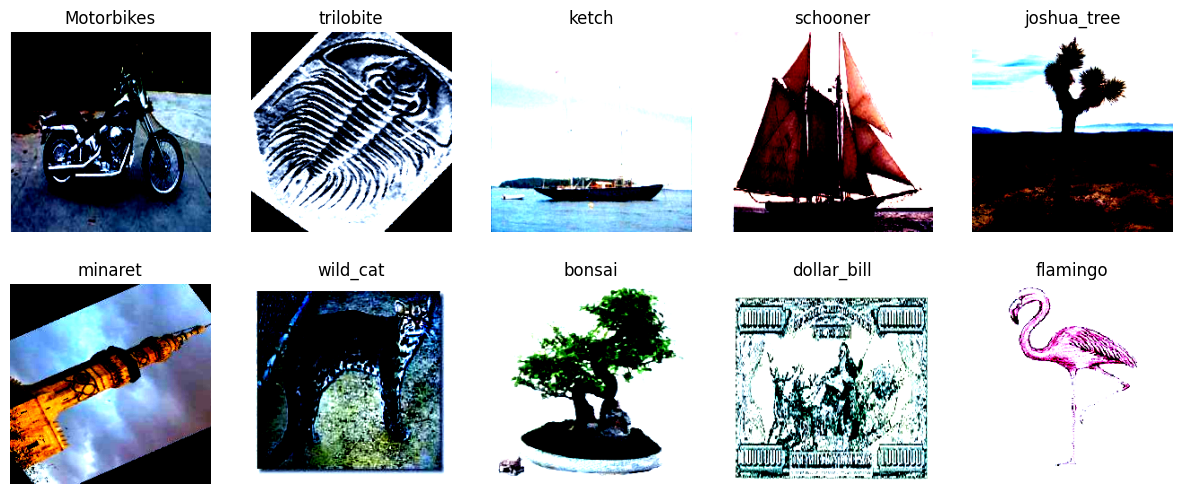

In [20]:
import matplotlib.pyplot as plt

def show_images(images, labels, classes):
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    axs = axs.flatten()
    for img, label, ax in zip(images, labels, axs):
        ax.imshow(img.permute(1, 2, 0).numpy())
        ax.axis('off')
        ax.set_title(classes[label])
    plt.show()

# Assuming 'train_dataset' is already loaded and transformed
images, labels = next(iter(train_loader))
# Convert labels back to original encoding to get class names
classes = lb.classes_
show_images(images[:10], labels[:10], classes)

Step 6: Training the Model.

This function processes the input data in batches, computes the loss, and updates the model's weights.

In [21]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses, test_accuracies = [], []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        test_accuracy = evaluate_model(model, test_loader)
        test_accuracies.append(test_accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    
    return train_losses, test_accuracies

Step 7: Run Training and Evaluation.


After training, evaluate the model's performance on a separate test set to ensure it generalizes well.

Epoch 1/10, Loss: 1.1529, Test Accuracy: 60.14%
Epoch 2/10, Loss: 1.0126, Test Accuracy: 59.22%
Epoch 3/10, Loss: 0.9009, Test Accuracy: 60.71%
Epoch 4/10, Loss: 0.8265, Test Accuracy: 60.25%
Epoch 5/10, Loss: 0.7500, Test Accuracy: 61.18%
Epoch 6/10, Loss: 0.6983, Test Accuracy: 61.87%
Epoch 7/10, Loss: 0.6330, Test Accuracy: 61.52%
Epoch 8/10, Loss: 0.5533, Test Accuracy: 62.10%
Epoch 9/10, Loss: 0.5092, Test Accuracy: 61.41%
Epoch 10/10, Loss: 0.5072, Test Accuracy: 61.75%


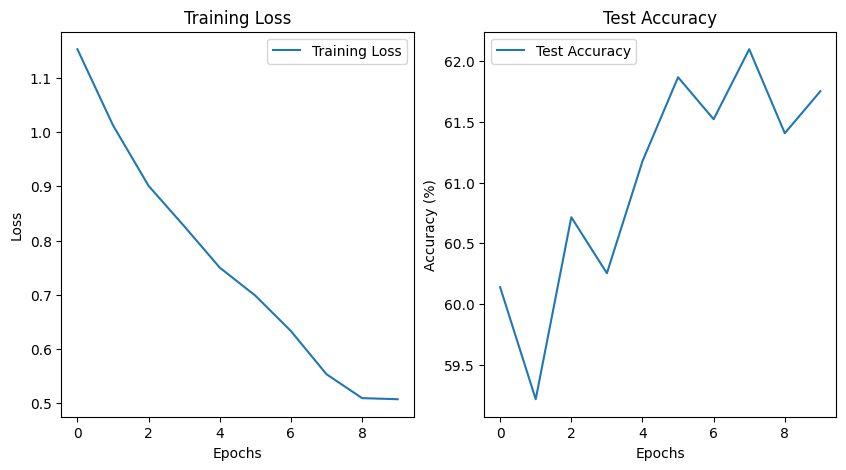

In [23]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# After training
train_losses, test_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()
plt.show()

Now, run the training and evaluation functions. Adjust the number of epochs based on your computational resources and how quickly your model is learning.D

Step 9: Model Saving and Loading 


Finally, after training and evaluating the model, you might want to save the model's state for future use or further evaluation.

In [ ]:
def visualize_incorrect_predictions(model, test_loader, classes):
    model.eval()
    incorrect_examples = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            incorrects = predicted != labels
            if incorrect_examples == []:
                incorrect_examples = inputs[incorrects].cpu()
                incorrect_labels = predicted[incorrects].cpu()
                correct_labels = labels[incorrects].cpu()
            else:
                incorrect_examples = torch.cat((incorrect_examples, inputs[incorrects].cpu()), dim=0)
                incorrect_labels = torch.cat((incorrect_labels, predicted[incorrects].cpu()), dim=0)
                correct_labels = torch.cat((correct_labels, labels[incorrects].cpu()), dim=0)
    
    show_images(incorrect_examples[:10], incorrect_labels[:10], classes)
    print('True labels:')
    print([classes[i] for i in correct_labels[:10]])
    print('Predicted labels:')
    print([classes[i] for i in incorrect_labels[:10]])

visualize_incorrect_predictions(model, test_loader, classes)

In [ ]:
# Save the model checkpoint
torch.save(model.state_dict(), 'zfnet_caltech101.pth')

# Load the model (if needed)
model.load_state_dict(torch.load('zfnet_caltech101.pth'))

Visualizing the feature maps generated by the convolutional layers of a network like ZFNet 
provides insights into what features the network is learning at various layers. 
To visualize these feature maps, you can modify the model to return outputs from intermediate layers in addition to the final output.

Modifying the Model for Feature Map Visualization
First, adjust the ZFNet model to allow fetching outputs from intermediate layers. This involves slightly refactoring the model definition:

In [ ]:
# class ZFNetModified(nn.Module):
#     def __init__(self, num_classes=101):
#         super(ZFNetModified, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             # Continue with other layers...
#         )
#         self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
#         self.classifier = nn.Sequential(
#             nn.Dropout(),
#             nn.Linear(256 * 6 * 6, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Linear(4096, num_classes),
#         )

#     def forward(self, x, return_feature_maps=False):
#         feature_maps = []
#         for layer in self.features:
#             x = layer(x)
#             if return_feature_maps:
#                 feature_maps.append(x)
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.classifier(x)
#         if return_feature_maps:
#             return x, feature_maps
#         return x


<!-- Visualizing Feature Maps
You can visualize the feature maps by plotting the activations after passing an image through the network. --> 

In [ ]:
# def visualize_feature_maps(model, loader):
#     model.eval()
#     images, _ = next(iter(loader))
#     image = images[0:1].to(device)  # Get the first image of the batch

#     # Forward pass to get feature maps
#     _, feature_maps = model(image, return_feature_maps=True)

#     # Visualize the first 5 feature maps of the first convolutional layer
#     fig, axarr = plt.subplots(1, 5)
#     for idx in range(5):
#         axarr[idx].imshow(feature_maps[0][0, idx].cpu().detach().numpy(), cmap='gray')
#         axarr[idx].axis('off')
#     plt.show()

# # Example usage
# model = ZFNetModified(num_classes=101).to(device)
# visualize_feature_maps(model, train_loader)
